In [261]:
import numpy as np
import mlmodel
import torch
import torch.nn as nn
import importlib
import torch
import dataloader
import pickle
import environment
import matplotlib.pyplot as plt
import processing_utils
importlib.reload(mlmodel)
importlib.reload(dataloader)
import torch.utils.data.dataloader
device = torch.device("cuda:1")

In [262]:
ocr_nn = mlmodel.load_model('try_2')

In [263]:
with open('/home/rohan/Desktop/ground_truth_V_train/env_53.pkl', 'rb') as f:
    env = pickle.load(f)

In [264]:
number_origins = 1
origins, origins_grid = processing_utils.sample_free_space(env.occupancy_grid, env.coordinate_vectors, number_origins)
theta_vals = np.linspace(-np.pi, np.pi, 100)
theta_vals = np.tile(np.linspace(-np.pi, np.pi, 100), (number_origins, 1))

In [265]:
xx, yy = np.meshgrid(env.coordinate_vectors[0], env.coordinate_vectors[1], indexing='xy')
print("Shape of coordinate grid:", xx.shape)
print("Each point represents (x,y) coordinate where x comes from coordinate_vectors[0] and y from coordinate_vectors[1]")
# Flatten and combine the coordinate grids
coords = np.column_stack((xx.flatten(), yy.flatten()))
print("Shape of coords matrix:", coords.shape)


Shape of coordinate grid: (100, 100)
Each point represents (x,y) coordinate where x comes from coordinate_vectors[0] and y from coordinate_vectors[1]
Shape of coords matrix: (10000, 2)


In [266]:
lidar_reading = env.read_lidar(
    positions = origins,
    thetas = theta_vals,
    min_distance = 0.2,
    max_distance = 10
)

In [267]:
print(origins)

[[2.37373734 4.090909   3.03687358]]


In [268]:
print(np.shape(lidar_reading))
lidar_reading_tiled = np.tile(lidar_reading, (10000, 1))
print(np.shape(lidar_reading_tiled))

(1, 100)
(10000, 100)


In [269]:
relative_positions = coords - origins[:, :2]
theta = np.tile(origins[0,-1], 10000)
relative_positions = np.hstack((relative_positions, theta.reshape(10000,1)))

In [270]:
input_ocr = np.hstack((relative_positions, lidar_reading_tiled))

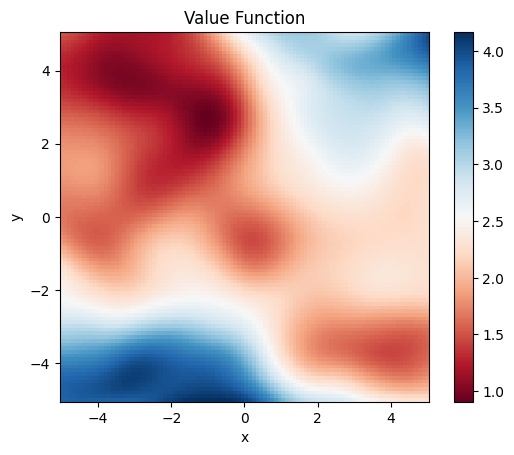

In [275]:
values = ocr_nn(torch.from_numpy(input_ocr).float()).detach().numpy()
coords = coords

# Reshape values and plot
grid_values = values.reshape(env.coordinate_vectors[1].size, env.coordinate_vectors[0].size)
plt.figure()
plt.pcolormesh(env.coordinate_vectors[0][::-1], env.coordinate_vectors[1], grid_values, cmap='RdBu')
plt.colorbar()
# plt.contour(env.coordinate_vectors[0], env.coordinate_vectors[1], grid_values, levels=0, colors='black', linewidths=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value Function')
plt.gca().set_aspect('equal')
values = ocr_nn(torch.from_numpy(input_ocr).float()).detach().numpy()
# Reshape values and plot
grid_values = values.reshape(env.coordinate_vectors[1].size, env.coordinate_vectors[0].size)
# Flip the grid values along the x-axis


In [272]:
print(np.max(values))

4.166966


In [273]:
env.visualize_grid(
    grid=env.value_grid,
    coordinate_vectors=env.coordinate_vectors,
    axis_dims=[0, 1],
    state_slice_indices=[None, None, 0],
    save_path='test',
    title='V(x,e) at th=0',
    axis_labels=['x', 'y'],
    legend_limit=None
)

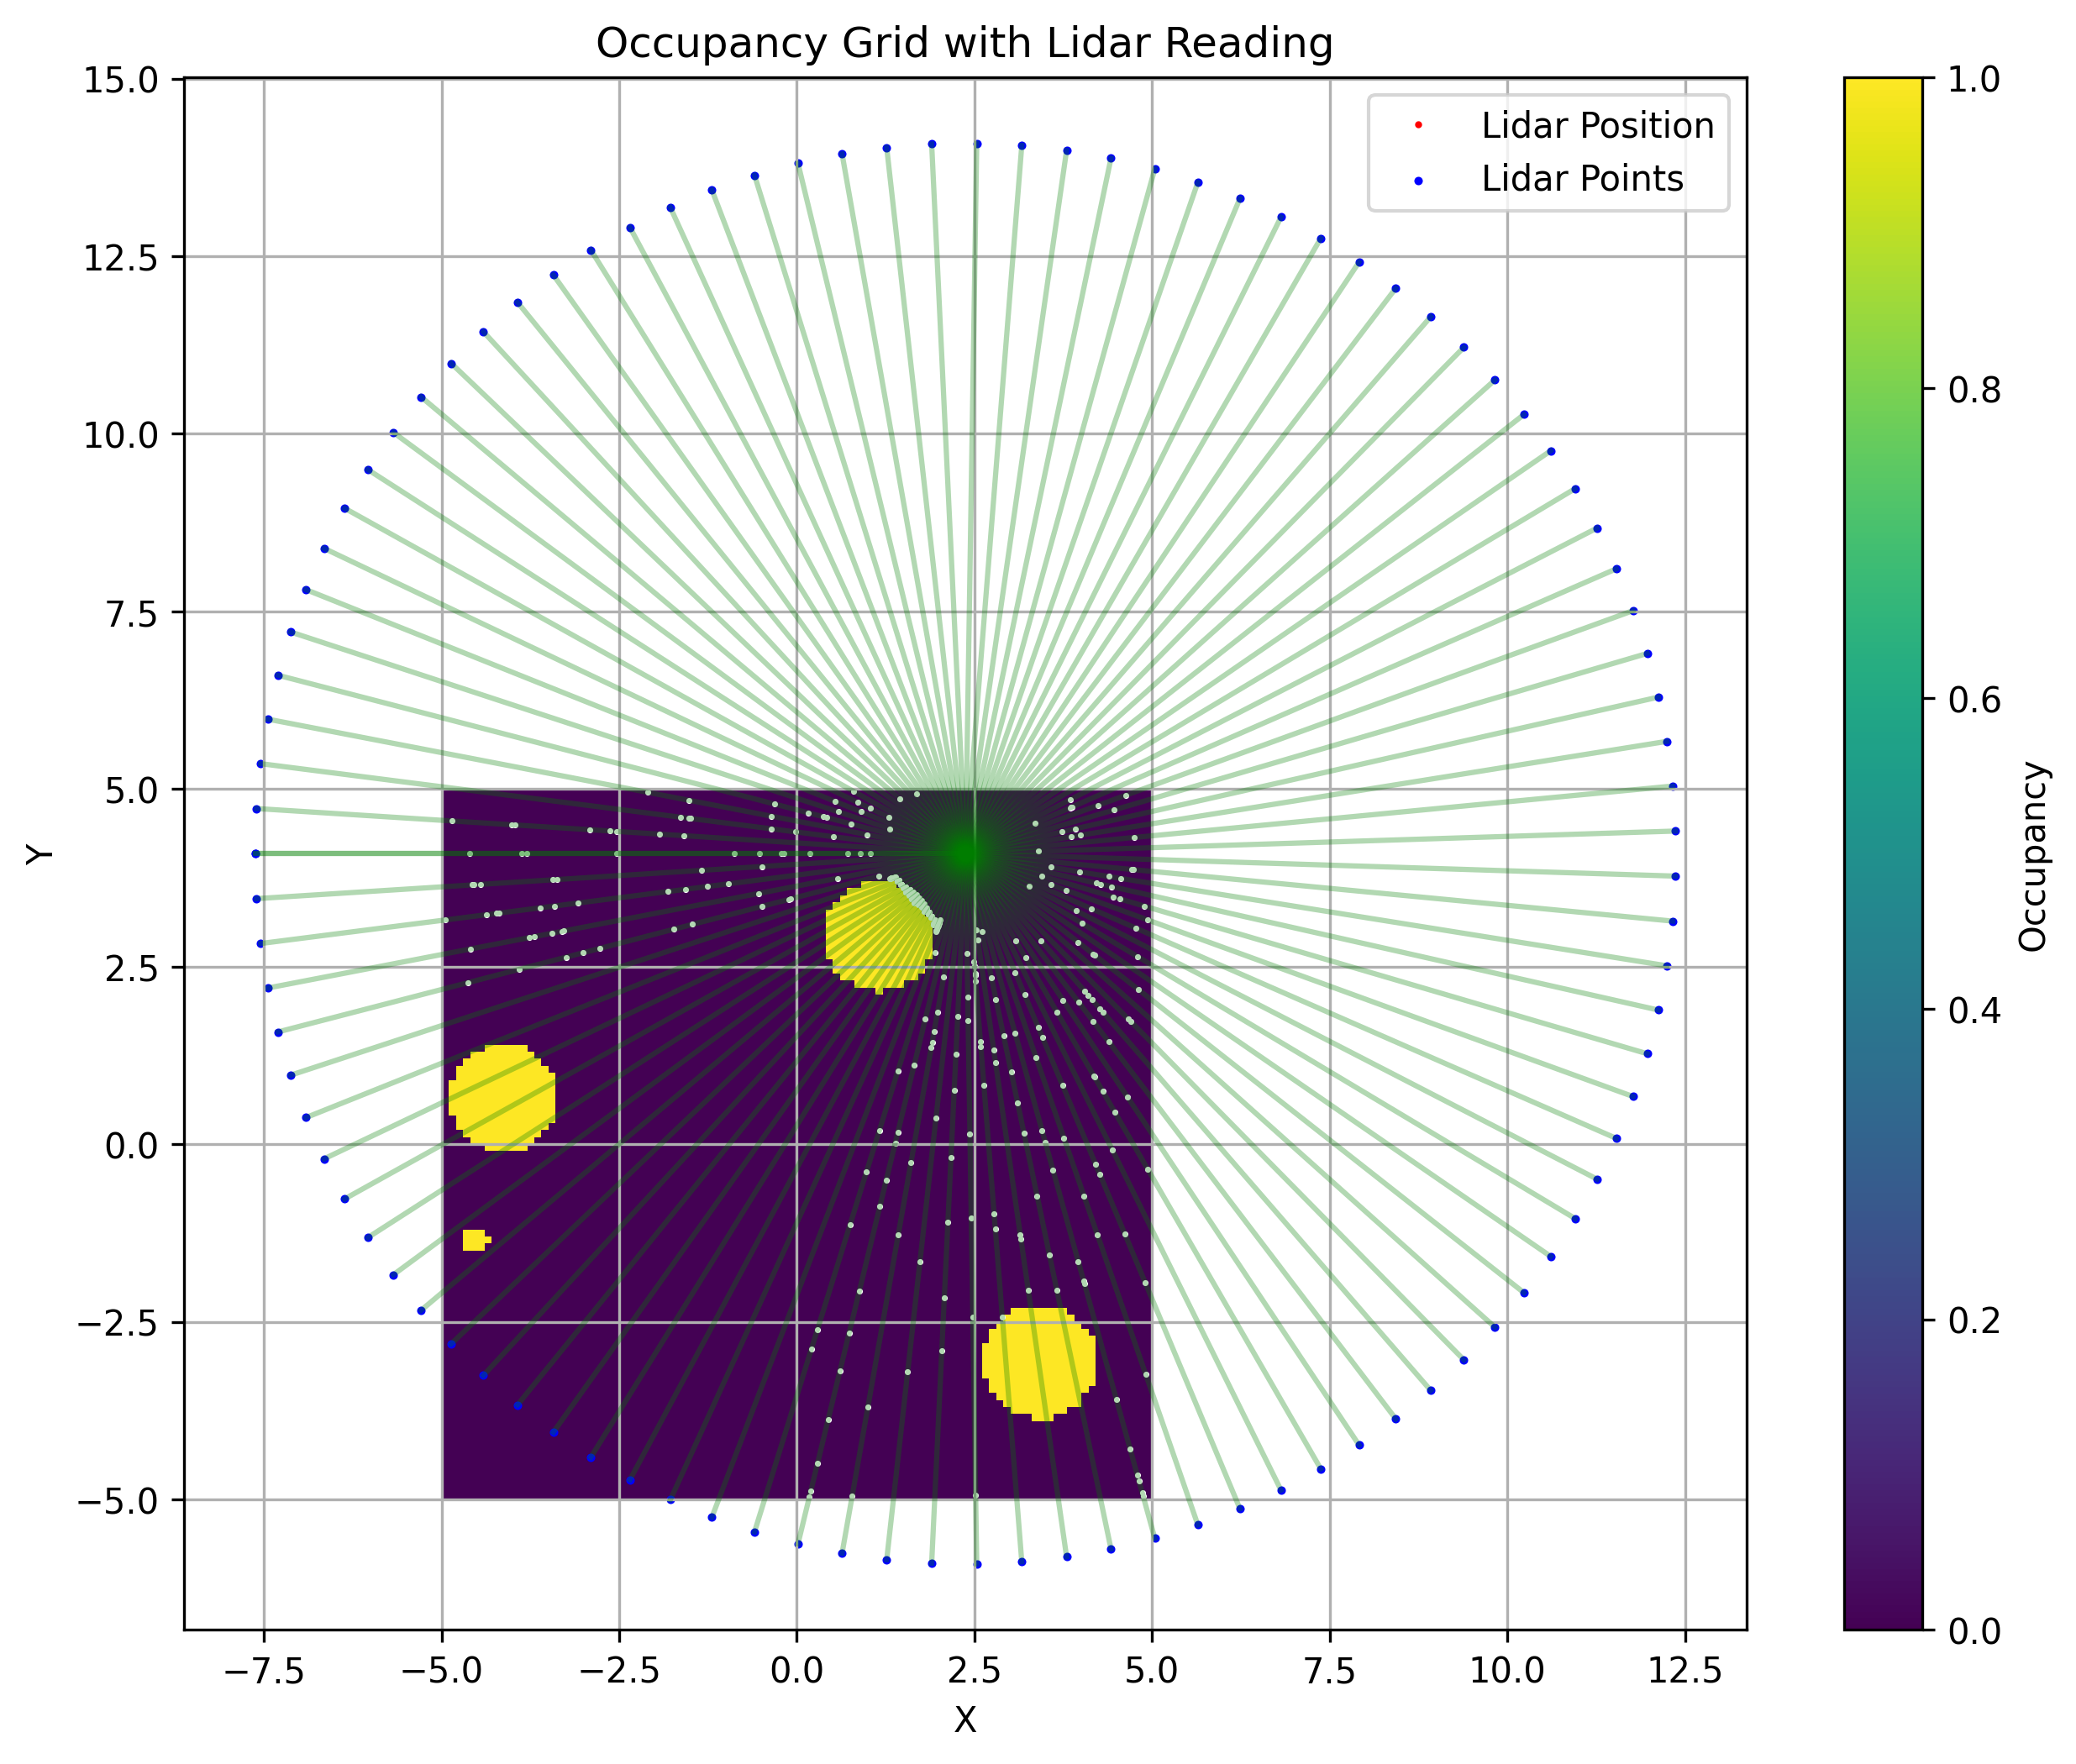

In [274]:
"""
Plotting the occupancy grid
"""
# plt.imshow(occupancy_grid[:,:,12], origin='lower', extent=[test_lidar.coordinate_vectors[0][0], test_lidar.coordinate_vectors[0][-1], test_lidar.coordinate_vectors[1][0], test_lidar.coordinate_vectors[1][-1]])
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.title("Occupancy Grid")
# plt.colorbar()
# plt.show()

# Create a figure for combined visualization
plt.figure(figsize=(10, 8))
test_sample_points = processing_utils.sample_non_occluded_points(
    origins, lidar_reading, 400
)
# Plot the occupancy grid as background
plt.imshow(env.occupancy_grid[:,:,12].T, origin='lower', extent=[env.coordinate_vectors[0][0], env.coordinate_vectors[0][-1], env.coordinate_vectors[1][0], env.coordinate_vectors[1][-1]])

# Mark the position from which lidar observation is taken
index_origin = 0

plt.plot(origins[index_origin, 0], origins[index_origin, 1], 'ro', markersize=1, label='Lidar Position')

# Convert lidar readings from polar to cartesian coordinates
x_points = origins[index_origin, 0] + lidar_reading[index_origin, 0] * np.cos(theta_vals[0])
y_points = origins[index_origin, 1] + lidar_reading[index_origin, 0] * np.sin(theta_vals[0])

# Plot the lidar rays
for i in range(len(theta_vals[0])):
    plt.plot([origins[index_origin, 0], x_points[i]], [origins[index_origin, 1], y_points[i]], 'g-', alpha=0.3)

# Plot the points where lidar rays end
plt.scatter(x_points, y_points, c='b', s=2, label='Lidar Points')


for i in range(test_sample_points.shape[1]):
    plt.scatter(test_sample_points[index_origin][i][0], test_sample_points[index_origin][i][1], s = 0.5, c='w')

plt.title("Occupancy Grid with Lidar Reading")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Occupancy")
plt.legend()
plt.axis('equal')
plt.grid(True)
# Increase the display DPI of the figure
plt.gcf().set_dpi(300)

# Optionally save the figure with high resolution
# plt.savefig('lidar_visualization_high_res.png', dpi=300, bbox_inches='tight')